Moj notebook

## Regresija

In [7]:
import pandas as pandas
import os
import json
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression


def read_population_by_sex():
    rows_to_skip = [i for i in range(0, 16)]  
    rows_to_skip.extend([i for i in range(17, 272)])   # odstranjevanje vrstic ki bi delale probleme
    rows_to_skip.extend([i for i in range(362, 377)])
    names  =["Region-Country", "Date", "0-4", "5-9",  "10-14", "15-19", "20-24", "25-29", 
             "30-34", "35-39", "40-44", "45-49", "50-54", "55-59",  "60-64", "65-69", "70-74", "75-79",
             "80-84", "85-89", "90-94", "95-99", "100+"]

    main_set = pandas.read_excel('podatki/POPULATION_BY_AGE_BOTH_SEXES.xlsx', 
                                 usecols=(2, 7, 8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28),
                                    skiprows=rows_to_skip,
                                    names=names)
    main_set["population_sum"] = np.NaN
    main_set["avg_age"] = np.NaN

    for index, row in main_set.iterrows():
        temp_sum = 0
        for num_range, num in row[2:-2].iteritems():
            temp_sum += num

        main_set.loc[index,"population_sum"] = float(temp_sum)

        pop_age = 0        # mogoče zamenji z mediano 
        age_range = 2
        for num_range, num in row[2:-2].iteritems():
            pop_age += (num / temp_sum) * age_range
            age_range += 5
        main_set.loc[index,"avg_age"] = float(pop_age)
    return main_set


pop_by_sex = read_population_by_sex() 

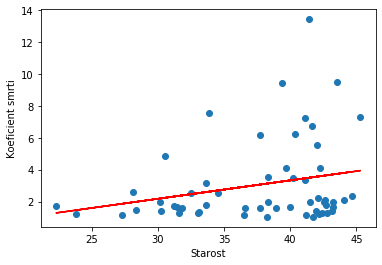

In [21]:
def priprava(avg_age_all_df,country):
    #priprava podatkov za starost
    avg_age_all_df = pop_by_sex.loc[:, ['Date','Region-Country', 'avg_age']] #avg_age_date_region-country
    avg_age_df = avg_age_all_df.loc[avg_age_all_df['Region-Country'] == country]
    avg_age_df_2020 = avg_age_df.loc[avg_age_df['Date'] == 2020]
    avg_age_df_spain = avg_age_df_2020.loc[avg_age_df['Region-Country'] == country]

    #priprava podatkov za corono
    corona_smrti_koeficient = pandas.read_csv(r"podatki\corona_latest.csv")
    corona_smrti_koeficient = corona_smrti_koeficient.loc[corona_smrti_koeficient['year'] == 2020]
    corona_smrti_koeficient = corona_smrti_koeficient.loc[corona_smrti_koeficient['countriesAndTerritories'] == country]
    corona_final1 = corona_smrti_koeficient.loc[:, ['deaths','popData2018']]
    corona_final_koeficient = corona_final1
    corona_final_koeficient['koeficient'] = ((corona_final_koeficient['deaths']*100)/corona_final_koeficient['popData2018']) *10000
    smrti_koeficienti = corona_final_koeficient.loc[:, ['koeficient']]
    smrti_koeficienti = smrti_koeficienti[smrti_koeficienti["koeficient"]!=0] #razlicen od 0
    smrti_koeficienti = smrti_koeficienti[smrti_koeficienti["koeficient"]>1] #vecji od 1
    smrti =smrti_koeficienti['koeficient'].mean()
    smrti
    smrt=[smrti]
    skupenDF2=avg_age_df_spain
    skupenDF2['koeficient']=smrt
    skupenDF2
    return skupenDF2

def iteracija_drzave(avg_age_all_df):
    drzave_df = avg_age_all_df.loc[:, ['Region-Country']]
    drzave_df = drzave_df['Region-Country'].unique()

    df_countries = priprava(avg_age_all_df,drzave_df[0])
    length = len(drzave_df) 
    i = 1
    # Iterating using while loop 
    while i < length: 
        df_countries = df_countries.append(priprava(avg_age_all_df,drzave_df[i]))
        i += 1

    df_countries = df_countries.dropna()
    return df_countries
    #df_countries = df_countries[df_countries["koeficient"]!=0]
def linearna():
    avg_age_all_df = pop_by_sex.loc[:, ['Date','Region-Country', 'avg_age']]
    df_countries = iteracija_drzave(avg_age_all_df)
    X = df_countries.iloc[:, 2].values.reshape(-1, 1) # values converts it into a numpy array
    Y = df_countries .iloc[:, 3].values.reshape(-1, 1) # -1 means that calculate the dimension of rows, but have 1 column
    linear_regressor = LinearRegression()
    linear_regressor.fit(X, Y)
    Y_pred = linear_regressor.predict(X)
    plt.scatter(X, Y)
    plt.plot(X, Y_pred, color='red')
    plt.xlabel("Starost")
    plt.ylabel("Koeficient smrti")
    plt.show()

linearna()